In [1]:
# Import required libraries
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.colors as mcolors
from scipy.optimize import minimize

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

from erm import RegularizedERM, ERMStabilityEstimator

In [2]:
# Load the COMPAS dataset
print("=" * 60)
print("Loading COMPAS data")
print("=" * 60)

df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]

# Scale COMPAS score to [0, 1]
df['compas_score_scaled'] = df['v_decile_score'] / 10.0

df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')

# Prepare labels and COMPAS scores
y = df.is_recid.to_numpy().astype(float)
f = df.compas_score_scaled.to_numpy().astype(float)  # COMPAS score as predictor

# Get race and sex dummies for group analysis
dummy_df_races = pd.get_dummies(df.race)
dummy_df_sexes = pd.get_dummies(df.sex)
races = dummy_df_races.values.astype(float)
sexes = dummy_df_sexes.values.astype(float)
order_races = dummy_df_races.columns.values.tolist()
order_sexes = dummy_df_sexes.columns.values.tolist()

# Build feature matrix for debiasing: intercept + race dummies + sex dummies
# Note: NOT including COMPAS score in X since that's what we're debiasing
X = np.column_stack([
    np.ones(len(y)),                         # intercept
    dummy_df_races.values.astype(float),     # race dummies
    dummy_df_sexes.values.astype(float)      # sex dummies
])

feature_names = ['intercept'] + order_races + order_sexes

print(f"Loaded {len(y)} samples with {X.shape[1]} features")
print(f"Features: {feature_names}")
print(f"Recidivism rate (y): {y.mean():.4f}")
print(f"Mean COMPAS score (f): {f.mean():.4f}")
print(f"COMPAS score range: [{f.min():.2f}, {f.max():.2f}]")
print(f"Mean bias (f - y): {(f - y).mean():.4f}")
print(f"\nGroups - Races: {order_races}")
print(f"Groups - Sexes: {order_sexes}")

Loading COMPAS data
Loaded 6787 samples with 6 features
Features: ['intercept', 'African-American', 'Caucasian', 'Hispanic', 'Female', 'Male']
Recidivism rate (y): 0.4871
Mean COMPAS score (f): 0.3742
COMPAS score range: [0.10, 1.00]
Mean bias (f - y): -0.1129

Groups - Races: ['African-American', 'Caucasian', 'Hispanic']
Groups - Sexes: ['Female', 'Male']


In [3]:
class OLS:
    """
    Ordinary Least Squares (Ridge Regression) using RegularizedERM with optional conservative guarantee.
    
    Solves: min_θ (1/n) Σ (y_i - x_i^T θ)² + (λ/2)||θ||² - γ 1_d^T θ
    
    The linear term -γ 1_d^T θ provides a conservative gradient guarantee.
    
    Provides vectorized fit and predict methods.
    """
    
    def __init__(self, lam=0.01, gamma=0.0):
        """
        Initialize OLS model.
        
        Parameters
        ----------
        lam : float
            Regularization parameter (ridge penalty)
        gamma : float or np.ndarray
            Linear term coefficient for conservative guarantee.
            If float: same gamma for all coordinates.
            If array: per-coordinate gamma (length d).
        """
        self.lam = lam
        self.gamma = gamma
        self.theta = None
        self.erm = None
    
    def _loss_fn(self, data, theta):
        """
        Squared loss: (y - x^T θ)²
        
        Parameters
        ----------
        data : tuple or array
            If tuple: (X, y) where X is (n, d) and y is (n,)
            If array: assumes structure is data[:, :-1] = X, data[:, -1] = y
        theta : np.ndarray
            Parameter vector (d,)
        
        Returns
        -------
        loss : np.ndarray
            Loss for each sample (n,)
        """
        if isinstance(data, tuple):
            X, y = data
        else:
            X = data[:, :-1]
            y = data[:, -1]
        
        predictions = X @ theta
        residuals = y - predictions
        return residuals ** 2
    
    def _grad_fn(self, data, theta):
        """
        Gradient of squared loss: -2(y - x^T θ) x
        
        Parameters
        ----------
        data : tuple or array
            If tuple: (X, y) where X is (n, d) and y is (n,)
            If array: assumes structure is data[:, :-1] = X, data[:, -1] = y
        theta : np.ndarray
            Parameter vector (d,)
        
        Returns
        -------
        gradient : np.ndarray
            Gradient for each sample (n, d)
        """
        if isinstance(data, tuple):
            X, y = data
        else:
            X = data[:, :-1]
            y = data[:, -1]
        
        predictions = X @ theta
        residuals = y - predictions
        return -2 * residuals[:, np.newaxis] * X
    
    def _objective_conservative(self, theta, loss_fn, data):
        """
        Regularized empirical risk with linear term: R̂_D(θ) + (λ/2)||θ||²_2 - γ 1_d^T θ
        """
        empirical_risk = loss_fn(data, theta).mean()
        regularization = 0.5 * self.lam * np.sum(theta ** 2)
        linear_term = -np.sum(self.gamma * theta)  # -γ 1_d^T θ
        return empirical_risk + regularization + linear_term
    
    def _gradient_conservative(self, theta, grad_fn, data):
        """
        Gradient with linear term: ∇R̂_D(θ) + λθ - γ 1_d
        """
        empirical_grad = grad_fn(data, theta).mean(axis=0)
        reg_grad = self.lam * theta
        linear_grad = -self.gamma if isinstance(self.gamma, np.ndarray) else -self.gamma * np.ones_like(theta)
        return empirical_grad + reg_grad + linear_grad
    
    def fit(self, X, y):
        """
        Fit OLS model to training data.
        
        Parameters
        ----------
        X : np.ndarray
            Feature matrix (n, d)
        y : np.ndarray
            Target vector (n,)
        
        Returns
        -------
        self : OLS
            Fitted model
        """
        # Store data as tuple for loss/grad functions
        data = (X, y)
        
        # Initialize theta
        d = X.shape[1]
        theta_init = np.zeros(d)
        
        # Convert gamma to array if needed
        if isinstance(self.gamma, (int, float)):
            gamma_arr = self.gamma * np.ones(d)
        else:
            gamma_arr = self.gamma
        
        # If gamma is non-zero, use custom optimization with conservative objective
        if np.any(gamma_arr != 0):
            self.gamma = gamma_arr
            result = minimize(
                fun=lambda theta: self._objective_conservative(theta, self._loss_fn, data),
                x0=theta_init,
                jac=lambda theta: self._gradient_conservative(theta, self._grad_fn, data),
                method='L-BFGS-B'
            )
            self.theta = result.x
        else:
            # Use standard RegularizedERM
            self.erm = RegularizedERM(lam=self.lam, theta_init=theta_init)
            self.theta = self.erm.fit(data, self._loss_fn, self._grad_fn)
        
        return self
    
    def predict(self, X):
        """
        Predict target values for new data.
        
        Parameters
        ----------
        X : np.ndarray
            Feature matrix (n, d)
        
        Returns
        -------
        predictions : np.ndarray
            Predicted values (n,)
        """
        if self.theta is None:
            raise ValueError("Model has not been fitted yet. Call fit() first.")
        
        return X @ self.theta


def precompute_beta_ols(X, y, lam=0.01, n_bootstrap=100):
    """
    Precompute stability parameter β for OLS using direct estimation.
    
    Uses ERMStabilityEstimator.estimate_beta_loss_direct() which implements:
    Δ^(b) = (1/(n+1)) Σ_i [ℓ(Z_i^(b); A(D_{-i}^(b))) - ℓ(Z_i^(b); A*(D^(b)))]
    β̂ = E[Δ]_+
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix (n, d)
    y : np.ndarray
        Target vector (n,)
    lam : float
        Regularization parameter
    n_bootstrap : int
        Number of bootstrap replicates
    
    Returns
    -------
    beta_hat : float
        Estimated stability parameter
    """
    # Create OLS instance to use its loss and gradient functions
    ols = OLS(lam=lam, gamma=0.0)
    
    # Prepare data as concatenated array for ERMStabilityEstimator
    data = np.concatenate([X, y[:, np.newaxis]], axis=1)
    
    # Create stability estimator
    estimator = ERMStabilityEstimator(lam=lam, n_bootstrap=n_bootstrap)
    
    # Estimate beta using direct method with OLS loss and gradient functions
    beta_hat = estimator.estimate_beta_loss_direct(
        data=data,
        loss_fn=ols._loss_fn,
        grad_fn=ols._grad_fn,
        theta_init=np.zeros(X.shape[1])
    )
    
    return beta_hat

In [4]:
# Fit OLS to debias GBT predictions
# Target: bias = f - y
# Model: bias ~ X (using OLS)
# Debiased prediction: f_debiased = f - X @ theta

bias = f - y  # Compute bias

# Standard OLS (no conservative guarantee)
print("=" * 60)
print("Standard OLS (gamma = 0)")
print("=" * 60)
ols_standard = OLS(lam=0.01, gamma=0.0)
ols_standard.fit(X, bias)
bias_pred_standard = ols_standard.predict(X)
f_debiased_standard = f - bias_pred_standard

print(f"Fitted coefficients (θ): {ols_standard.theta}")
print(f"MSE (bias): {ols_standard._loss_fn((X, bias), ols_standard.theta).mean():.6f}")
print(f"Mean bias: {bias.mean():.6f}")
print(f"Mean predicted bias: {bias_pred_standard.mean():.6f}")
print(f"Mean debiased prediction: {f_debiased_standard.mean():.6f}")
print(f"Mean original prediction (f): {f.mean():.6f}")
print(f"Mean true label (y): {y.mean():.6f}")

# Precompute beta for OLS (this may take a while with bootstrap)
print("\n" + "=" * 60)
print("Precomputing β (stability parameter)")
print("=" * 60)
print("Note: This uses bootstrap with leave-one-out. May take a few minutes...")
beta_hat = precompute_beta_ols(X, bias, lam=0.01, n_bootstrap=1)  # Fewer bootstraps for demo
print(f"Estimated β: {beta_hat:.6f}")

# Conservative OLS with gamma = beta
print("\n" + "=" * 60)
print(f"Conservative OLS (gamma = β = {beta_hat:.6f})")
print("=" * 60)
ols_conservative = OLS(lam=0.01, gamma=beta_hat)
ols_conservative.fit(X, bias)
bias_pred_conservative = ols_conservative.predict(X)
f_debiased_conservative = f - bias_pred_conservative

print(f"Fitted coefficients (θ): {ols_conservative.theta}")
print(f"MSE (bias): {ols_conservative._loss_fn((X, bias), ols_conservative.theta).mean():.6f}")
print(f"Mean predicted bias: {bias_pred_conservative.mean():.6f}")
print(f"Mean debiased prediction: {f_debiased_conservative.mean():.6f}")

# Compare predictions
print("\n" + "=" * 60)
print("Comparison")
print("=" * 60)
print(f"Difference in coefficients (L2): {np.linalg.norm(ols_conservative.theta - ols_standard.theta):.6f}")
print(f"Max absolute difference in coefficients: {np.max(np.abs(ols_conservative.theta - ols_standard.theta)):.6f}")
print(f"Mean absolute difference in bias predictions: {np.mean(np.abs(bias_pred_conservative - bias_pred_standard)):.6f}")
print(f"Mean absolute difference in debiased predictions: {np.mean(np.abs(f_debiased_conservative - f_debiased_standard)):.6f}")

Standard OLS (gamma = 0)
Fitted coefficients (θ): [-0.04941364 -0.02222616 -0.03558187  0.0083944  -0.00123376 -0.04817988]
MSE (bias): 0.237699
Mean bias: -0.112878
Mean predicted bias: -0.112630
Mean debiased prediction: 0.486861
Mean original prediction (f): 0.374230
Mean true label (y): 0.487108

Precomputing β (stability parameter)
Note: This uses bootstrap with leave-one-out. May take a few minutes...
Estimated β: 0.000263

Conservative OLS (gamma = β = 0.000263)
Fitted coefficients (θ): [-0.0659099  -0.01038444 -0.02369585  0.0208461   0.00389353 -0.04346558]
MSE (bias): 0.237699
Mean predicted bias: -0.112417
Mean debiased prediction: 0.486647

Comparison
Difference in coefficients (L2): 0.027517
Max absolute difference in coefficients: 0.016496
Mean absolute difference in bias predictions: 0.000213
Mean absolute difference in debiased predictions: 0.000213


Running 100 train-test splits...
Beta used for conservative method: 0.000263
Progress: 10...20...30...40...50...60...70...80...90...100... Done!


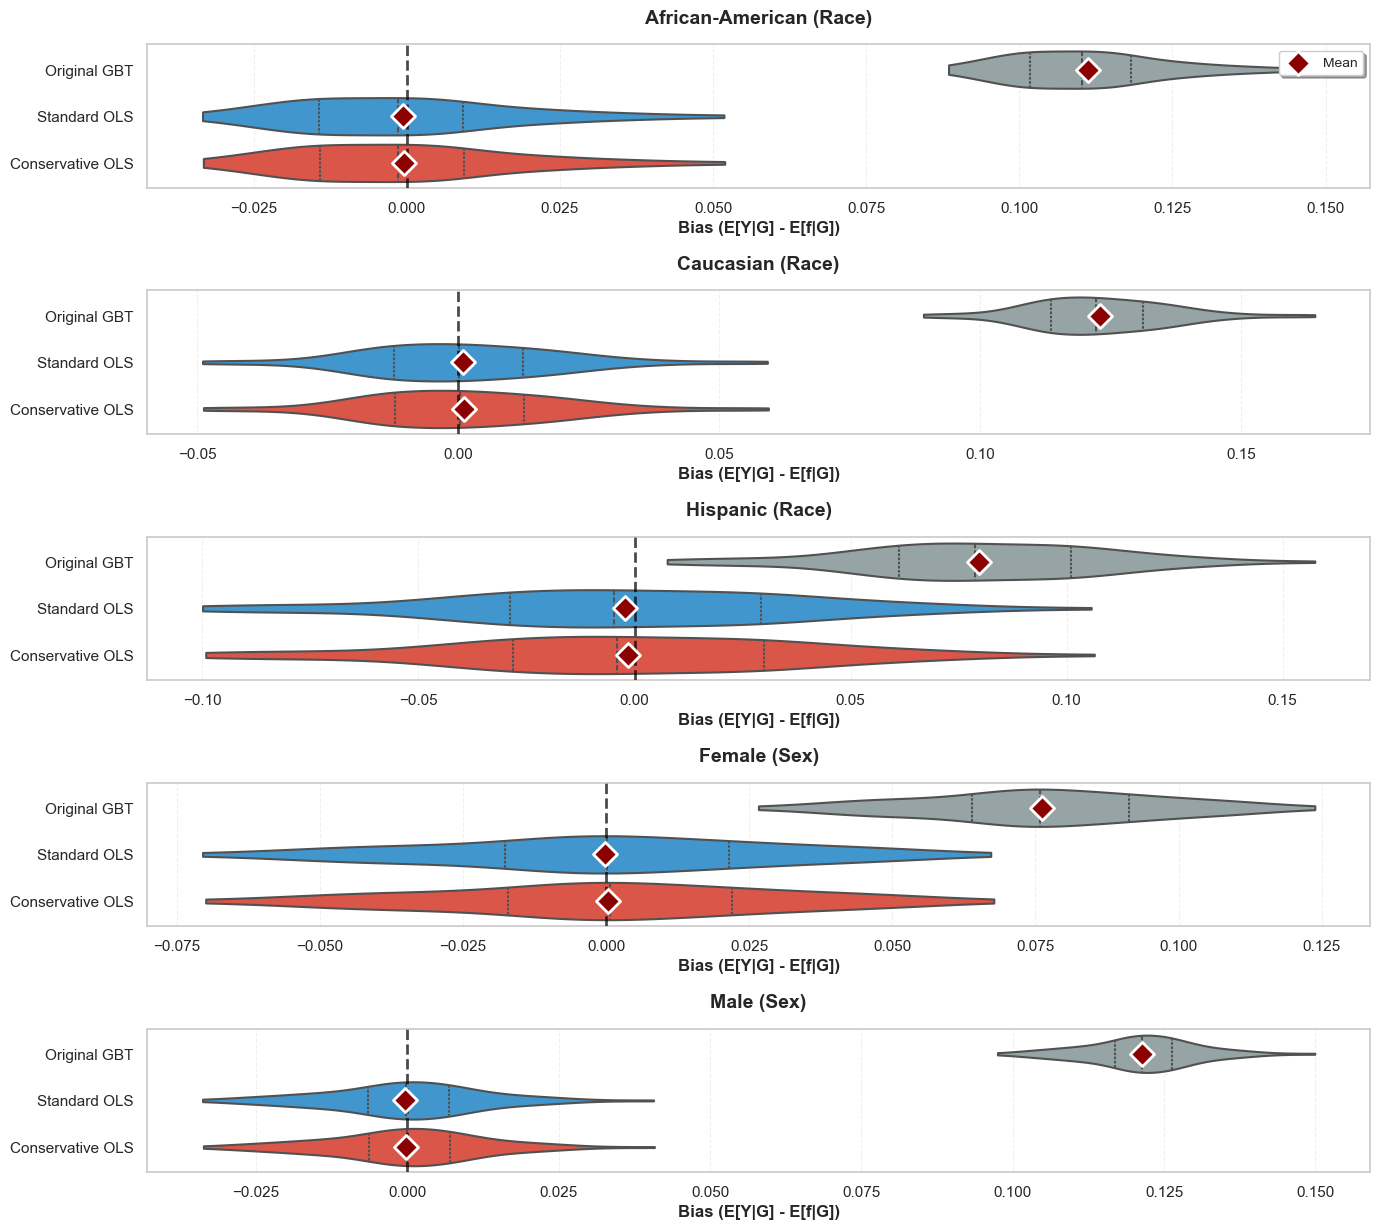


Summary Statistics: Bias Distribution Across 100 Splits
Group                Method               Mean         Std          |Mean|      
----------------------------------------------------------------------------------------------------
African-American     Original GBT         +0.111142   0.012881   0.111142
                     Standard OLS         -0.000664   0.018279   0.000664
                     Conservative OLS     -0.000531   0.018279   0.000531
                     Reduction (Std)      +0.110478
                     Reduction (Cons)     +0.110611
----------------------------------------------------------------------------------------------------
Caucasian            Original GBT         +0.122965   0.013541   0.122965
                     Standard OLS         +0.000852   0.019374   0.000852
                     Conservative OLS     +0.001053   0.019375   0.001053
                     Reduction (Std)      +0.122113
                     Reduction (Cons)     +0.121912
--------

In [5]:
# Compute per-group bias over 100 random train-test splits
def compute_group_bias(y_true, y_pred, group_indicators, group_names):
    """
    Compute bias for each group: E[Y | G=1] - E[pred | G=1]
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predictions (probabilities)
    group_indicators : np.ndarray
        Binary indicators for group membership (n, k)
    group_names : list
        Names of groups
    
    Returns
    -------
    biases : dict
        Dictionary mapping group names to bias values
    """
    biases = {}
    for i, group_name in enumerate(group_names):
        group_mask = group_indicators[:, i] == 1
        if group_mask.sum() > 0:
            bias = y_true[group_mask].mean() - y_pred[group_mask].mean()
            biases[group_name] = bias
    return biases

# Run 100 train-test splits and collect biases
n_splits = 100
test_size = 0.3
results = {
    'original': {group: [] for group in order_races + order_sexes},
    'standard': {group: [] for group in order_races + order_sexes},
    'conservative': {group: [] for group in order_races + order_sexes}
}

print(f"Running {n_splits} train-test splits...")
print(f"Beta used for conservative method: {beta_hat:.6f}")
print("Progress: ", end="", flush=True)

for split_idx in range(n_splits):
    if (split_idx + 1) % 10 == 0:
        print(f"{split_idx + 1}...", end="", flush=True)
    
    # Random train-test split
    n = len(y)
    indices = np.random.permutation(n)
    split_point = int(n * (1 - test_size))
    train_idx = indices[:split_point]
    test_idx = indices[split_point:]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    f_train, f_test = f[train_idx], f[test_idx]
    races_test = races[test_idx]
    sexes_test = sexes[test_idx]
    
    # Compute bias on training set
    bias_train = f_train - y_train
    
    # Fit standard OLS
    ols_standard = OLS(lam=0.01, gamma=0.0)
    ols_standard.fit(X_train, bias_train)
    bias_pred_standard = ols_standard.predict(X_test)
    f_debiased_standard = f_test - bias_pred_standard
    
    # Fit conservative OLS
    ols_conservative = OLS(lam=0.01, gamma=beta_hat)
    ols_conservative.fit(X_train, bias_train)
    bias_pred_conservative = ols_conservative.predict(X_test)
    f_debiased_conservative = f_test - bias_pred_conservative
    
    # Compute biases for races
    race_bias_orig = compute_group_bias(y_test, f_test, races_test, order_races)
    race_bias_std = compute_group_bias(y_test, f_debiased_standard, races_test, order_races)
    race_bias_cons = compute_group_bias(y_test, f_debiased_conservative, races_test, order_races)
    
    # Compute biases for sexes
    sex_bias_orig = compute_group_bias(y_test, f_test, sexes_test, order_sexes)
    sex_bias_std = compute_group_bias(y_test, f_debiased_standard, sexes_test, order_sexes)
    sex_bias_cons = compute_group_bias(y_test, f_debiased_conservative, sexes_test, order_sexes)
    
    # Store results
    for group in order_races:
        results['original'][group].append(race_bias_orig[group])
        results['standard'][group].append(race_bias_std[group])
        results['conservative'][group].append(race_bias_cons[group])
    for group in order_sexes:
        results['original'][group].append(sex_bias_orig[group])
        results['standard'][group].append(sex_bias_std[group])
        results['conservative'][group].append(sex_bias_cons[group])

print(" Done!")

# Convert results to long-format DataFrame for seaborn
all_groups = order_races + order_sexes
plot_data = []
for group in all_groups:
    for method in ['Original GBT', 'Standard OLS', 'Conservative OLS']:
        method_key = {'Original GBT': 'original', 'Standard OLS': 'standard', 'Conservative OLS': 'conservative'}[method]
        for bias_value in results[method_key][group]:
            plot_data.append({
                'Group': group,
                'Method': method,
                'Bias': bias_value,
                'Category': 'Race' if group in order_races else 'Sex'
            })

df_plot = pd.DataFrame(plot_data)

# Set up beautiful seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Create color palette
colors = {
    'Original GBT': '#95a5a6',  # Gray
    'Standard OLS': '#3498db',  # Blue
    'Conservative OLS': '#e74c3c'  # Red
}

# Create stacked violin plots
fig, axes = plt.subplots(len(all_groups), 1, figsize=(14, 2.5 * len(all_groups)))

if len(all_groups) == 1:
    axes = [axes]

for i, group in enumerate(all_groups):
    ax = axes[i]
    
    # Filter data for this group
    group_data = df_plot[df_plot['Group'] == group]
    
    # Create violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=group_data,
        x='Bias',
        y='Method',
        hue='Method',
        order=['Original GBT', 'Standard OLS', 'Conservative OLS'],
        palette=colors,
        orient='h',
        ax=ax,
        inner='quartile',
        linewidth=1.5,
        saturation=0.85,
        cut=0,
        legend=False
    )
    
    # Add zero line
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=10)
    
    # Add mean markers
    for j, method in enumerate(['Original GBT', 'Standard OLS', 'Conservative OLS']):
        method_key = {'Original GBT': 'original', 'Standard OLS': 'standard', 'Conservative OLS': 'conservative'}[method]
        mean_val = np.mean(results[method_key][group])
        ax.scatter(mean_val, j, color='darkred', s=150, marker='D', zorder=20, 
                  edgecolors='white', linewidths=2, label='Mean' if j == 0 else '')
    
    # Styling
    category = 'Race' if group in order_races else 'Sex'
    ax.set_title(f'{group} ({category})', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Bias (E[Y|G] - E[f|G])', fontsize=12, fontweight='semibold')
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Add legend only to first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:1], ['Mean'], loc='upper right', frameon=True, 
                 fancybox=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 100)
print("Summary Statistics: Bias Distribution Across 100 Splits")
print("=" * 100)
print(f"{'Group':<20} {'Method':<20} {'Mean':<12} {'Std':<12} {'|Mean|':<12}")
print("-" * 100)
for group in all_groups:
    mean_orig = np.mean(results['original'][group])
    std_orig = np.std(results['original'][group])
    mean_std = np.mean(results['standard'][group])
    std_std = np.std(results['standard'][group])
    mean_cons = np.mean(results['conservative'][group])
    std_cons = np.std(results['conservative'][group])
    
    print(f"{group:<20} {'Original GBT':<20} {mean_orig:+.6f}   {std_orig:.6f}   {abs(mean_orig):.6f}")
    print(f"{'':<20} {'Standard OLS':<20} {mean_std:+.6f}   {std_std:.6f}   {abs(mean_std):.6f}")
    print(f"{'':<20} {'Conservative OLS':<20} {mean_cons:+.6f}   {std_cons:.6f}   {abs(mean_cons):.6f}")
    reduction_std = abs(mean_orig) - abs(mean_std)
    reduction_cons = abs(mean_orig) - abs(mean_cons)
    print(f"{'':<20} {'Reduction (Std)':<20} {reduction_std:+.6f}")
    print(f"{'':<20} {'Reduction (Cons)':<20} {reduction_cons:+.6f}")
    print("-" * 100)